In [1]:
import pandas as pd
import polars as pl
import polars.selectors as cs

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pl.Config.set_tbl_width_chars(200)

polars.config.Config

In [3]:
path  = './yt_dataset/GBvideos.csv'

### Data

In [4]:
%%time
df_pl = pl.read_csv(path)

CPU times: user 160 ms, sys: 76.2 ms, total: 236 ms
Wall time: 74.9 ms


### Common Exploratory Methods

In [5]:
print(df_pl.shape)
print(df_pl.head(2))
#print(df_pl.tail(2))
#print(df_pl.sample(2))

(38916, 16)
shape: (2, 16)
┌─────────────┬───────────────┬─────────────────────────────────┬─────────────────────┬───┬───────────────────┬──────────────────┬────────────────────────┬─────────────────────────────────┐
│ video_id    ┆ trending_date ┆ title                           ┆ channel_title       ┆ … ┆ comments_disabled ┆ ratings_disabled ┆ video_error_or_removed ┆ description                     │
│ ---         ┆ ---           ┆ ---                             ┆ ---                 ┆   ┆ ---               ┆ ---              ┆ ---                    ┆ ---                             │
│ str         ┆ str           ┆ str                             ┆ str                 ┆   ┆ bool              ┆ bool             ┆ bool                   ┆ str                             │
╞═════════════╪═══════════════╪═════════════════════════════════╪═════════════════════╪═══╪═══════════════════╪══════════════════╪════════════════════════╪═════════════════════════════════╡
│ Jw1Y-zhQURU ┆ 17.14.1

In [6]:
import polars.selectors as cs

# Polars feature selectiom
numeric_data_pl = df_pl.select(cs.numeric())
categorical_data_pl = df_pl.select(cs.string())
print(numeric_data_pl.head())

shape: (5, 5)
┌─────────────┬──────────┬────────┬──────────┬───────────────┐
│ category_id ┆ views    ┆ likes  ┆ dislikes ┆ comment_count │
│ ---         ┆ ---      ┆ ---    ┆ ---      ┆ ---           │
│ i64         ┆ i64      ┆ i64    ┆ i64      ┆ i64           │
╞═════════════╪══════════╪════════╪══════════╪═══════════════╡
│ 26          ┆ 7224515  ┆ 55681  ┆ 10247    ┆ 9479          │
│ 24          ┆ 1053632  ┆ 25561  ┆ 2294     ┆ 2757          │
│ 10          ┆ 17158579 ┆ 787420 ┆ 43420    ┆ 125882        │
│ 17          ┆ 27833    ┆ 193    ┆ 12       ┆ 37            │
│ 25          ┆ 9815     ┆ 30     ┆ 2        ┆ 30            │
└─────────────┴──────────┴────────┴──────────┴───────────────┘


In [7]:
susbet_pl = df_pl[["likes", "views", "comment_count"]]
print(susbet_pl.head())

shape: (5, 3)
┌────────┬──────────┬───────────────┐
│ likes  ┆ views    ┆ comment_count │
│ ---    ┆ ---      ┆ ---           │
│ i64    ┆ i64      ┆ i64           │
╞════════╪══════════╪═══════════════╡
│ 55681  ┆ 7224515  ┆ 9479          │
│ 25561  ┆ 1053632  ┆ 2757          │
│ 787420 ┆ 17158579 ┆ 125882        │
│ 193    ┆ 27833    ┆ 37            │
│ 30     ┆ 9815     ┆ 30            │
└────────┴──────────┴───────────────┘


In [8]:
# how many rows in the dataset have less than 1000 views
filtered_pl = df_pl.filter(pl.col("views") < 1000)
filtered_pl.shape

(6, 16)

### Data Quality Checks

In [9]:
# check for the number of missing rows per column and the number of static columns
missing = (
    df_pl.select(pl.all().is_null().sum())
    .melt(value_name="missing")
    .filter(pl.col("missing") > 0)
)
static = (
    df_pl.select(pl.all().n_unique())
    .melt(value_name="unique")
    .filter(pl.col("unique") == 1)
)
print("Missing columns:")
print(missing)

print("nStatic columns:")
print(static)

Missing columns:
shape: (0, 2)
┌──────────┬─────────┐
│ variable ┆ missing │
│ ---      ┆ ---     │
│ str      ┆ u32     │
╞══════════╪═════════╡
└──────────┴─────────┘
nStatic columns:
shape: (0, 2)
┌──────────┬────────┐
│ variable ┆ unique │
│ ---      ┆ ---    │
│ str      ┆ u32    │
╞══════════╪════════╡
└──────────┴────────┘


/tmp/ipykernel_27562/1542734511.py:3: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  df_pl.select(pl.all().is_null().sum())
/tmp/ipykernel_27562/1542734511.py:8: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  df_pl.select(pl.all().n_unique())


### Data Pre-Processing
- Convert date columns into datetime format
- Replace category IDs with the actual category names


In [11]:
# Polars datetime conversion
df_pl = df_pl.with_columns(
    pl.col('trending_date').str.to_date(format='%y.%d.%m'),
    pl.col('publish_time').str.to_datetime()
)

In [13]:
### ikigai book

In [21]:
import json

with open('./yt_dataset/US_category_id.json', 'r') as f:
    categories = json.load(f)
    
id_to_category = {}
for c in categories['items']:
    id_to_category[int(c['id'])] = c['snippet']['title']

In [26]:
# df_pl = df_pl.with_columns(pl.col("category_id").map_dict(id_to_category))
df_pl = df_pl.with_columns(
    pl.col("category_id").replace_strict(id_to_category, default="Unknown").alias("category")
)

### Basic Exploratory Data Analysis

This section will cover the some of the most important techniques when doing EDA, namely univariate data analysis, aggregates, and visualisations.

Univariate data analysis is the simplest analysis you can do yet it’s crucial. Looking at one variable at a time, it can give you a better sense of data and can guide your further explorations.

In [34]:
category_counts = df_pl['category'].value_counts(sort=True).head()
print(category_counts)

shape: (5, 2)
┌──────────────────┬───────┐
│ category         ┆ count │
│ ---              ┆ ---   │
│ str              ┆ u32   │
╞══════════════════╪═══════╡
│ Music            ┆ 13754 │
│ Entertainment    ┆ 9124  │
│ People & Blogs   ┆ 2926  │
│ Film & Animation ┆ 2577  │
│ Howto & Style    ┆ 1928  │
└──────────────────┴───────┘


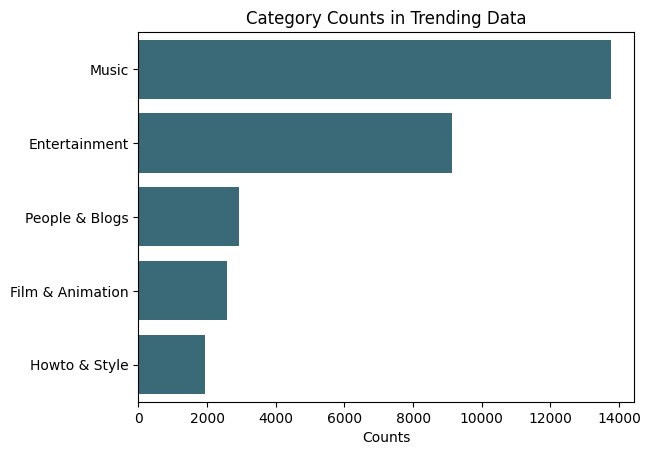

In [37]:
# Barplot
sns.barplot(
    y=category_counts["category"].to_numpy(),
    x=category_counts["count"].to_numpy(),
    color="#306e81",
)
plt.title("Category Counts in Trending Data")
plt.xlabel("Counts")
plt.show()

shape: (9, 2)
┌────────────┬──────────────┐
│ statistic  ┆ views        │
│ ---        ┆ ---          │
│ str        ┆ f64          │
╞════════════╪══════════════╡
│ count      ┆ 38916.0      │
│ null_count ┆ 0.0          │
│ mean       ┆ 5.9119e6     │
│ std        ┆ 1.9001e7     │
│ min        ┆ 851.0        │
│ 25%        ┆ 251532.0     │
│ 50%        ┆ 982006.0     │
│ 75%        ┆ 3.683523e6   │
│ max        ┆ 4.24538912e8 │
└────────────┴──────────────┘


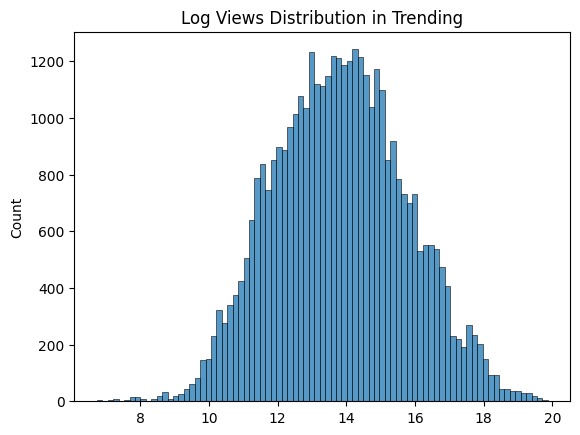

In [38]:
views_stats = df_pl.select(pl.col("views")).describe()
print(views_stats)

sns.histplot(df_pl['views'].log())
plt.title("Log Views Distribution in Trending")
plt.show()

### Multivariate Data Analysis

First things first, which channels appear most frequently in the trending page? We can again use .value_counts() but let’s use the .groupby().agg() method instead since it’s much more flexible and will be useful going forward. I’m going to group by the channel title and count the number of rows using .count() method

In [41]:
channel_popularity = (
    df_pl.group_by(pl.col("channel_title"))
    .agg(pl.len().alias("trending_count"))
    .sort(pl.col("trending_count"), descending=True)
)

print(channel_popularity.head())

shape: (5, 2)
┌─────────────────────────────────┬────────────────┐
│ channel_title                   ┆ trending_count │
│ ---                             ┆ ---            │
│ str                             ┆ u32            │
╞═════════════════════════════════╪════════════════╡
│ The Tonight Show Starring Jimm… ┆ 208            │
│ Jimmy Kimmel Live               ┆ 207            │
│ TheEllenShow                    ┆ 207            │
│ Saturday Night Live             ┆ 206            │
│ WWE                             ┆ 205            │
└─────────────────────────────────┴────────────────┘


Let’s create a few other statistics namely:

- Number of unique trendy videos
- Total number of views, likes and comments
- Average number of views likes and comments


In [44]:
channel_stats_pl = df_pl.group_by("channel_title").agg(
    pl.len().alias("trending_count"), # number of occurences in the dataset
    pl.col("title").n_unique().alias("number_of_trending_videos"), # number of unique trending videos
    pl.col("views").sum().alias("total_views"), # total number of views
    pl.col("likes").sum().alias("total_likes"), # total number of likes
    pl.col("comment_count").sum().alias("total_comments"), # total number of comments
    pl.col("views").mean().alias("average_views"), # average number of views
    pl.col("likes").mean().alias("average_likes"), # average number of likes
    pl.col("comment_count").mean().alias("average_comments"), # average number of comments
)
print(channel_stats_pl.sample(5))

shape: (5, 9)
┌────────────────────────┬────────────────┬───────────────────────────┬─────────────┬───┬────────────────┬───────────────┬───────────────┬──────────────────┐
│ channel_title          ┆ trending_count ┆ number_of_trending_videos ┆ total_views ┆ … ┆ total_comments ┆ average_views ┆ average_likes ┆ average_comments │
│ ---                    ┆ ---            ┆ ---                       ┆ ---         ┆   ┆ ---            ┆ ---           ┆ ---           ┆ ---              │
│ str                    ┆ u32            ┆ u32                       ┆ i64         ┆   ┆ i64            ┆ f64           ┆ f64           ┆ f64              │
╞════════════════════════╪════════════════╪═══════════════════════════╪═════════════╪═══╪════════════════╪═══════════════╪═══════════════╪══════════════════╡
│ ESSENCE                ┆ 5              ┆ 1                         ┆ 572491      ┆ … ┆ 1715           ┆ 114498.2      ┆ 1903.2        ┆ 343.0            │
│ Golden State Times     ┆ 18         

#### refactor the aggregation code into a function

In [48]:
def make_aggregates(df: pl.DataFrame, group_by: str, agg_features: list[str]) -> pl.DataFrame:
    # Aggregates that measure popularity using video counts
    popularity_aggs = [
        pl.len().alias("trending_count"),
        pl.col("title").n_unique().alias("number_of_trending_videos"),
    ]
    # Aggregates that measure popularity using metrics of the videos
    metrics_agg = []
    for agg in agg_features:
        if agg not in df.columns:
            print(f"{agg} not in the dataframe. Skipping...")
        else:
            metrics_agg.append(pl.col(agg).sum().alias(f"total_{agg}"))
            metrics_agg.append(pl.col(agg).mean().alias(f"average_{agg}"))

    stats = df.group_by(group_by).agg(popularity_aggs + metrics_agg)
    stats = stats.sort("trending_count", descending=True)
    return stats

In [52]:
channel_aggs = make_aggregates(
    df = df_pl, 
    group_by = "channel_title", 
    agg_features = ["views", "likes", "comment_count"]
)
category_aggs = make_aggregates(
    df = df_pl, 
    group_by = "category", 
    agg_features = ["views", "likes", "comment_count"]
)

print("Top Channels")
print(channel_aggs.head())

print("nTop Categories")
print(category_aggs.head())

Top Channels
shape: (5, 9)
┌─────────────────────────────────┬────────────────┬───────────────────────────┬─────────────┬───┬─────────────┬───────────────┬─────────────────────┬───────────────────────┐
│ channel_title                   ┆ trending_count ┆ number_of_trending_videos ┆ total_views ┆ … ┆ total_likes ┆ average_likes ┆ total_comment_count ┆ average_comment_count │
│ ---                             ┆ ---            ┆ ---                       ┆ ---         ┆   ┆ ---         ┆ ---           ┆ ---                 ┆ ---                   │
│ str                             ┆ u32            ┆ u32                       ┆ i64         ┆   ┆ i64         ┆ f64           ┆ i64                 ┆ f64                   │
╞═════════════════════════════════╪════════════════╪═══════════════════════════╪═════════════╪═══╪═════════════╪═══════════════╪═════════════════════╪═══════════════════════╡
│ The Tonight Show Starring Jimm… ┆ 208            ┆ 51                        ┆ 447390019   ┆ … ┆